In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.transforms import InterpolationMode
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import make_grid
import cv2
import math

In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.maxpool_conv(x)

In [5]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [8]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode="bilinear"):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s, device="cuda") for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor).to("cuda")

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer("grid", grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode, padding_mode="border")

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [10]:
class DTLoss(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(DTLoss, self).__init__()
    
    def dist_t(self, image_gray):
	
        # Binary image
        # The threshold results will be a tuple, with [value, image]
        image_th = cv2.threshold(image_gray,50,255,cv2.THRESH_BINARY)[1]
        # cv2.imwrite("image_f_dist.jpg", image_th)

        # Invert images
        image_inv = (255-image_th)

        ### Distance transform

        # Distance transformation of background
        dist_t_bg = cv2.distanceTransform(image_inv, cv2.DIST_L2, 3)

        # Distance transformation of characters or patterns
        dist_t_fg = cv2.distanceTransform(image_th, cv2.DIST_L2, 3)

        # Make new distance transformation with (-) inside & (+) background
        dist_template = dist_t_bg + dist_t_fg*(-1)
        
        # Image float
        image_float = image_gray/255.0

        # Multiply pixel-wise with dist1
        mult = np.multiply(image_float, dist_template)

        # Sum of all elements in multiplied mult
        dist_sum = np.sum(mult)

        # return only dist_t_g as dist_template, dist_sum
        return dist_template, dist_sum

    def forward(self, origs, gens): # モデルの出力と正解データ
        dist_loss = 0
        for orig, gen in zip(origs, gens):
            orig_copy = orig.clone().detach().reshape(64, 64, 1).cpu().numpy()
            orig_copy += 1
            orig_copy *= 127.5
            dist_template_inf, orig_sum = self.dist_t(orig_copy.astype(np.uint8))
            orig = orig.reshape(64, 64, 1)
            orig = orig + 1
            orig *= 127.5
            orig /= 255.0
            gen = gen.reshape(64, 64, 1)
            gen = gen + 1
            gen *= 127.5
            gen /= 255.0
            dist_template = np.power(dist_template_inf,16)
            dist_template[dist_template>np.power(2,30)] = np.power(2,30)
            dist_template = torch.from_numpy(dist_template).clone().to("cuda")
            orig_dist = orig * dist_template
            gen_dist = gen * dist_template
            dist_loss += torch.sum(torch.pow(orig_dist - gen_dist, 2))
        return dist_loss / 16

In [11]:
class NCCLoss(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(NCCLoss, self).__init__()

    def forward(self, outputs, targets): # モデルの出力と正解データ
        for i, (output, target) in enumerate(zip(outputs, targets)):
            output_mean = torch.mean(output)
            target_mean = torch.mean(target)
            output2 = output - output_mean
            target2 = output - target_mean
            output2, target2 = output2.view(-1), target2.view(-1)
            numerator  = torch.dot(output2, target2) ** 2
            denominator = torch.dot(output2, output2) * torch.dot(target2, target2)
            if i == 0:
                loss = numerator / denominator
            else:
                loss += (numerator / denominator)
        return loss

In [12]:
class SMOOTHLoss(nn.Module):
    """
    N-D gradient loss.
    """

    def __init__(self, penalty='l1', loss_mult=None):
        super(SMOOTHLoss, self).__init__()
        self.penalty = penalty
        self.loss_mult = loss_mult

    def _diffs(self, y):
        vol_shape = [n for n in y.shape][2:]
        ndims = len(vol_shape)

        df = [None] * ndims
        for i in range(ndims):
            d = i + 2
            # permute dimensions
            r = [d, *range(0, d), *range(d + 1, ndims + 2)]
            y = y.permute(r)
            dfi = y[1:, ...] - y[:-1, ...]

            # permute back
            # note: this might not be necessary for this loss specifically,
            # since the results are just summed over anyway.
            r = [*range(d - 1, d + 1), *reversed(range(1, d - 1)), 0, *range(d + 1, ndims + 2)]
            df[i] = dfi.permute(r)

        return df

    def forward(self, y_pred):
        if self.penalty == 'l1':
            dif = [torch.abs(f) for f in self._diffs(y_pred)]
        else:
            assert self.penalty == 'l2', 'penalty can only be l1 or l2. Got: %s' % self.penalty
            dif = [f * f for f in self._diffs(y_pred)]

        df = [torch.mean(torch.flatten(f, start_dim=1), dim=-1) for f in dif]
        grad = sum(df) / len(df)

        if self.loss_mult is not None:
            grad *= self.loss_mult

        return grad.mean()

In [13]:
def imshow(img):
    img = make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [15]:
def train(model, device, train_loader, optimizer, epoch, rmodel_list, alphabet, lamda):
    criterion1 = DTLoss()
    # criterion1 = nn.MSELoss()
    criterion2 = SMOOTHLoss()
    model.train()
    count = 0
    MSE_list = []
    SMOOTH_list = []
    REG_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        if target[0].item() != alphabet or target[15].item() != alphabet:
            count += 1
            continue
        batch_idx -= count
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        flow = model(data)
        transformer = SpatialTransformer(size=(64, 64))
        output = transformer(data, flow)
        output_reg = rmodel_list[alphabet](output)
        loss1 = 1e-23 * criterion1(data, output)
        # loss1 = criterion1(data, output)
        loss2 = criterion2(flow)
        loss3 = (100 - output_reg.mean()) ** 2
        loss = loss1 + loss2 + lamda * loss3
        MSE_list.append(loss1.item())
        SMOOTH_list.append(loss2.item())
        REG_list.append(lamda * loss3.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(data) * (len(train_loader) - count),100. * batch_idx / (len(train_loader) - count), loss.item()))
            iterator = list(iter(output))
            imshow(iterator)
    return MSE_list, SMOOTH_list, REG_list
    

In [16]:
def val(model, device, val_loader, rmodel_list, alphabet, lamda):
    criterion1 = DTLoss()
    # criterion1 = nn.MSELoss()
    criterion2 = SMOOTHLoss()
    model.eval()
    count = 0
    loss1 = 0
    loss2 = 0
    loss3 = 0
    with torch.no_grad():
        for data, target in val_loader:
            if target[0].item() != alphabet or target[15].item() != alphabet:
                count += 1
                continue
            data = data.to(device, dtype=torch.float)
            flow = model(data)
            # f = flow[0].detach().clone().cpu()
            # H = []
            # S = []
            # for i in range(64):
            #     h = []
            #     s = []
            #     for j in range(64):
            #         length = np.sqrt(f[0][i][j] ** 2 + f[1][i][j] ** 2)
            #         h.append((math.degrees(math.acos(f[1][i][j] / length)) / 180) * 255)
            #         s.append(length)
            #     H.append(h)
            #     S.append(s)
            # H = np.array(H)
            # S = np.array(S)
            # S_max = S.max()
            # S = (S / S_max) * 255
            # V = np.ones([64, 64]) * 255
            # optical_f = np.array([H, S, V]).transpose(1, 2, 0).astype(np.uint8)
            # img = cv2.cvtColor(optical_f,cv2.COLOR_HSV2BGR)
            # plt.imshow(img)
            # plt.show()
            transformer = SpatialTransformer(size=(64, 64))
            output = transformer(data, flow)
            output_reg = rmodel_list[alphabet](output)
            loss1 += (1e-23 * criterion1(data, output).item())
            # loss1 += criterion1(data, output).item()
            loss2 += criterion2(flow).item()
            loss3 += lamda * ((100 - output_reg.mean().item())**2)  # sum up batch loss
    loss1 /= (len(val_loader) - count)
    loss2 /= (len(val_loader) - count)
    loss3 /= (len(val_loader) - count)
    
    print("{}:{}:{}".format(loss1, loss2, loss3))
    return loss1 + loss2 + loss3, loss1, loss2, loss3

In [17]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, alphabet="A"):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = "../model/voxelmorph_" + alphabet + ".pth"    #ベストモデル格納path

    def __call__(self, val_loss, model, alphabet, lamda):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model, alphabet, lamda)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model, alphabet, lamda)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model, alphabet, lamda):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), "../model/voxelmorph/" + chr(alphabet + 65) + "/weight/" + chr(alphabet + 65) + "_lamda{}.pth".format(lamda))  #ベストモデルを指定したpathに保存
        torch.save(model.state_dict(), "../attack_result_voxelmorph_test_MSE/model/" + chr(alphabet + 65) + "_DT.pth")  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

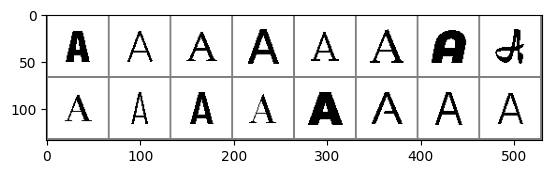

In [18]:
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64, 64), interpolation=InterpolationMode.NEAREST),
        transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
mean = (0.5,)
std = (0.5,)
batch_size = 16
images_train = ImageFolder( "../data/GoogleFonts/train2", transform = ImageTransform(mean, std))
train_loader = DataLoader(images_train, batch_size = batch_size, shuffle = False, drop_last=True)
images_val = ImageFolder( "../data/GoogleFonts/val2", transform = ImageTransform(mean, std))
val_loader = DataLoader(images_val, batch_size = batch_size, shuffle = False, drop_last=True)
iterator = iter(train_loader)
x, _ = next(iterator)
imshow(x)

/home/hoge/.local/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Train Epoch: 1 [0/27088 (0%)]	Loss: 0.953896


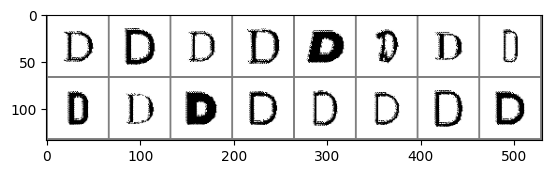

0.004753698166214749:0.008957841712981463:0.6331482846699655
Validation loss decreased (inf --> 0.646860).  Saving model ...
Train Epoch: 2 [0/27088 (0%)]	Loss: 0.606265


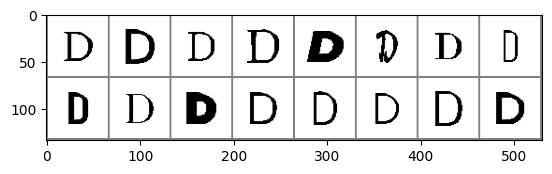

0.013980295624827652:0.013834352977573872:0.6023600315233318
Validation loss decreased (0.646860 --> 0.630175).  Saving model ...
Train Epoch: 3 [0/27088 (0%)]	Loss: 0.590073


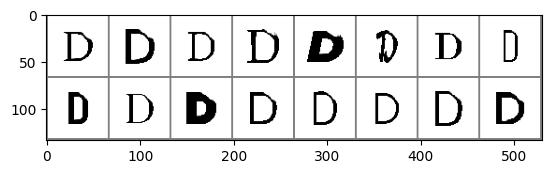

0.0155430195035148:0.013316604495048522:0.5972265791575386
Validation loss decreased (0.630175 --> 0.626086).  Saving model ...
Train Epoch: 4 [0/27088 (0%)]	Loss: 0.585633


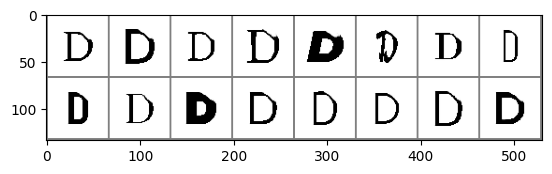

0.016727293802090003:0.01610232088714838:0.592169352585679
Validation loss decreased (0.626086 --> 0.624999).  Saving model ...
Train Epoch: 5 [0/27088 (0%)]	Loss: 0.583100


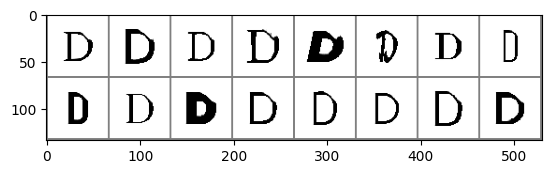

0.012642481300425154:0.011624822579324245:0.5886323692612343
Validation loss decreased (0.624999 --> 0.612900).  Saving model ...
Train Epoch: 6 [0/27088 (0%)]	Loss: 0.576173


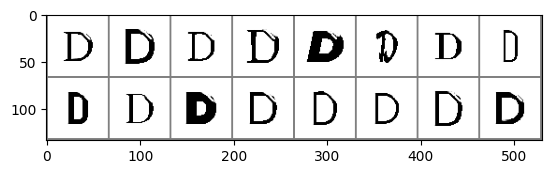

0.012948308858802118:0.011346204299479723:0.5869006062540911
Validation loss decreased (0.612900 --> 0.611195).  Saving model ...
Train Epoch: 7 [0/27088 (0%)]	Loss: 0.572162


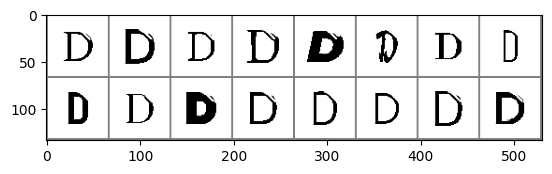

0.015262274321050009:0.013556164223700762:0.5793688695488906
Validation loss decreased (0.611195 --> 0.608187).  Saving model ...
Train Epoch: 8 [0/27088 (0%)]	Loss: 0.570512


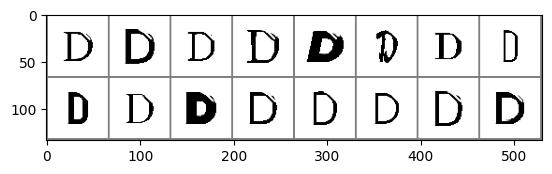

0.01548060355332912:0.013341087382286787:0.5781917633395183
Validation loss decreased (0.608187 --> 0.607013).  Saving model ...
Train Epoch: 9 [0/27088 (0%)]	Loss: 0.569910


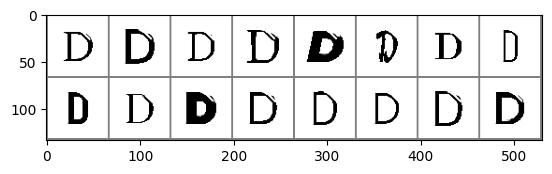

0.015109072346669746:0.012393905408680439:0.5779730396934659
Validation loss decreased (0.607013 --> 0.605476).  Saving model ...
Train Epoch: 10 [0/27088 (0%)]	Loss: 0.569436


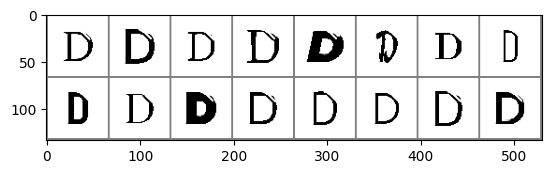

0.014013648720718003:0.01121872989460826:0.5803528117903507
EarlyStopping counter: 1 out of 10
Train Epoch: 11 [0/27088 (0%)]	Loss: 0.569537


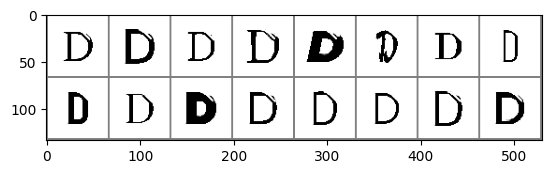

0.014171682635285971:0.011285252775996924:0.5792458486240792
Validation loss decreased (0.605476 --> 0.604703).  Saving model ...
Train Epoch: 12 [0/27088 (0%)]	Loss: 0.569338


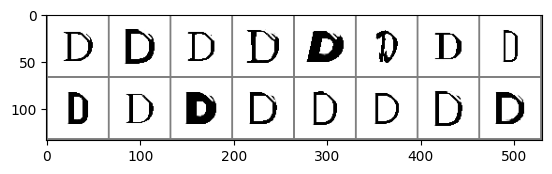

0.014331687437640864:0.011363932024687528:0.5785275103106868
Validation loss decreased (0.604703 --> 0.604223).  Saving model ...
Train Epoch: 13 [0/27088 (0%)]	Loss: 0.569231


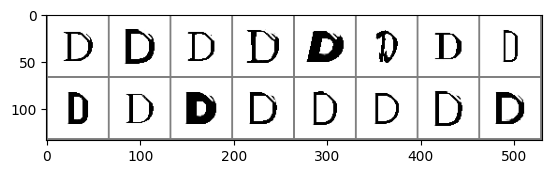

0.014853147557282561:0.011691024526953697:0.5770975283476285
Validation loss decreased (0.604223 --> 0.603642).  Saving model ...
Train Epoch: 14 [0/27088 (0%)]	Loss: 0.568992


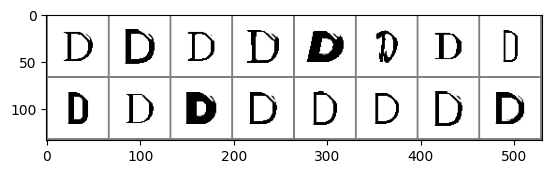

0.015150878206479462:0.01192930992692709:0.5763063996754589
Validation loss decreased (0.603642 --> 0.603387).  Saving model ...
Train Epoch: 15 [0/27088 (0%)]	Loss: 0.569027


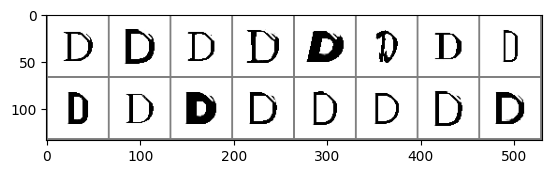

0.01531792213505194:0.012072128802537918:0.5759178535262782
Validation loss decreased (0.603387 --> 0.603308).  Saving model ...
Train Epoch: 16 [0/27088 (0%)]	Loss: 0.568949


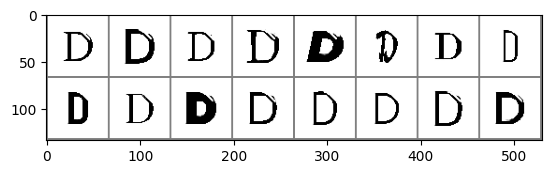

0.015434080946965915:0.01219258327037096:0.5756687092669851
Validation loss decreased (0.603308 --> 0.603295).  Saving model ...
Train Epoch: 17 [0/27088 (0%)]	Loss: 0.568903


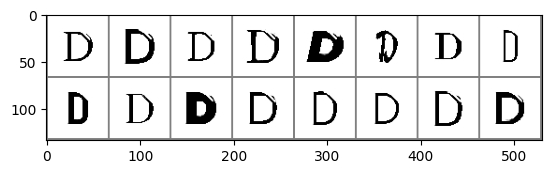

0.015479190619314775:0.012243376206606626:0.575551854224875
Validation loss decreased (0.603295 --> 0.603274).  Saving model ...
Train Epoch: 18 [0/27088 (0%)]	Loss: 0.568870


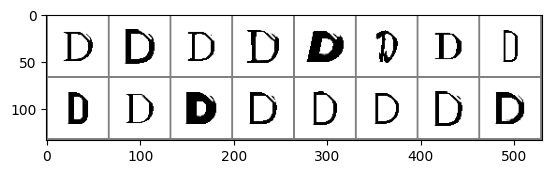

0.015495645576084538:0.012263451144099236:0.5755024789538989
Validation loss decreased (0.603274 --> 0.603262).  Saving model ...
Train Epoch: 19 [0/27088 (0%)]	Loss: 0.568834


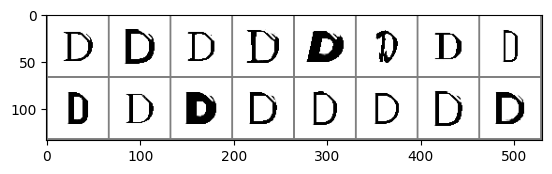

0.015503091855855928:0.01227089473977685:0.5754764980340695
Validation loss decreased (0.603262 --> 0.603250).  Saving model ...
Train Epoch: 20 [0/27088 (0%)]	Loss: 0.568817


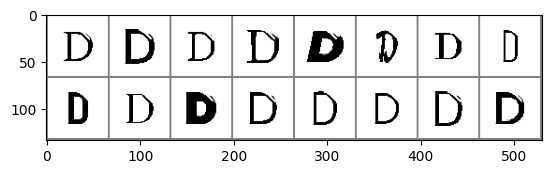

0.01550641304947488:0.012272887956351041:0.5754628926353001
Validation loss decreased (0.603250 --> 0.603242).  Saving model ...
Train Epoch: 21 [0/27088 (0%)]	Loss: 0.568790


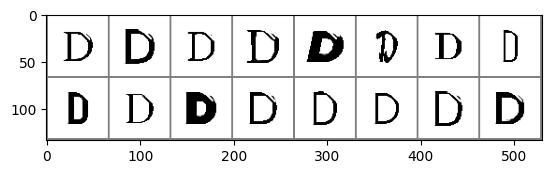

0.015515140392234028:0.012281598895788193:0.5754450440003798
Validation loss decreased (0.603242 --> 0.603242).  Saving model ...
Train Epoch: 22 [0/27088 (0%)]	Loss: 0.568774


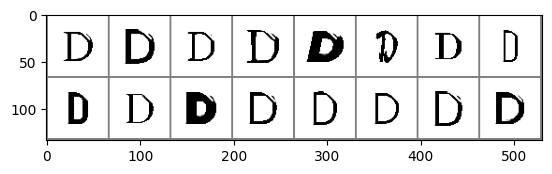

0.015522076006028923:0.012288280762732029:0.575433581878223
EarlyStopping counter: 1 out of 10
Train Epoch: 23 [0/27088 (0%)]	Loss: 0.568758


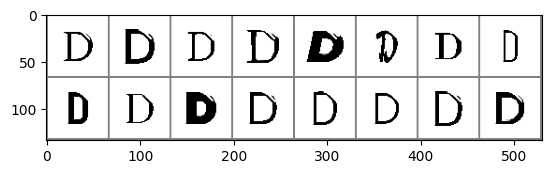

0.015525845237442054:0.01229167403653264:0.5754261147901409
EarlyStopping counter: 2 out of 10
Train Epoch: 24 [0/27088 (0%)]	Loss: 0.568747


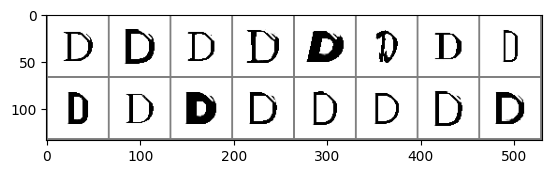

0.015527519943184739:0.012293739523738623:0.57542223947644
EarlyStopping counter: 3 out of 10
Train Epoch: 25 [0/27088 (0%)]	Loss: 0.568740


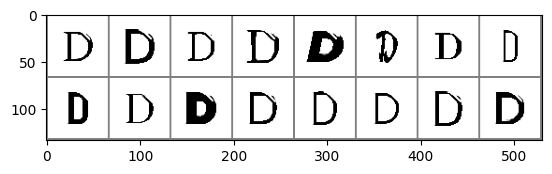

0.015528782217717797:0.012295268010348082:0.5754199060721696
EarlyStopping counter: 4 out of 10
Train Epoch: 26 [0/27088 (0%)]	Loss: 0.568735


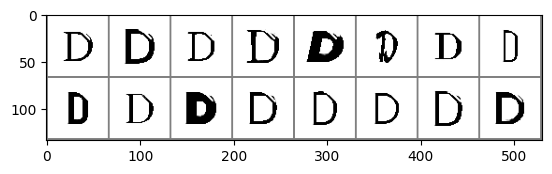

0.01552999051942407:0.012296064477413892:0.5754188152409564
EarlyStopping counter: 5 out of 10
Train Epoch: 27 [0/27088 (0%)]	Loss: 0.568732


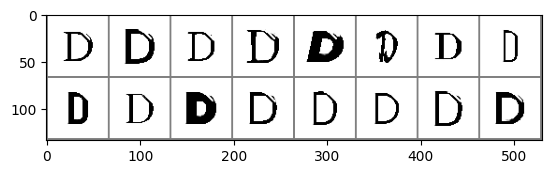

0.015530828892642201:0.012296733446419239:0.5754172984626924
EarlyStopping counter: 6 out of 10
Train Epoch: 28 [0/27088 (0%)]	Loss: 0.568730


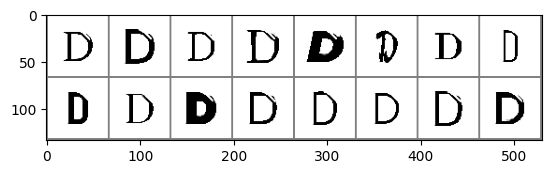

0.015531423156686786:0.0122972521930933:0.5754163906747419
EarlyStopping counter: 7 out of 10
Train Epoch: 29 [0/27088 (0%)]	Loss: 0.568729


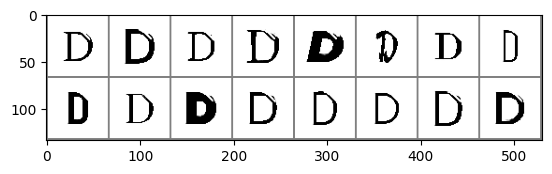

0.015532010172750719:0.012297983095049859:0.5754150645000579
EarlyStopping counter: 8 out of 10
Train Epoch: 30 [0/27088 (0%)]	Loss: 0.568727


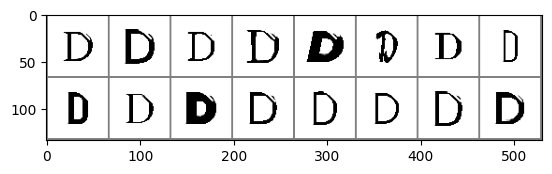

0.015532286370071615:0.012298181466758252:0.5754146708492462
EarlyStopping counter: 9 out of 10
Train Epoch: 31 [0/27088 (0%)]	Loss: 0.568727


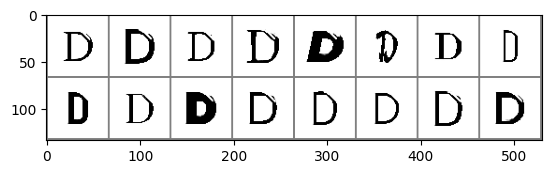

0.015532391500975412:0.01229833932593465:0.5754142799608695
EarlyStopping counter: 10 out of 10
Early Stopping!


In [19]:
rmodel_list = []
for i in range(26):
    pretrained_model = "../model/reg/reg_" + chr(i + 65) + ".pth"
    # if i == 0:
    #     pretrained_model = "../model/reg_" + chr(i + 65) + "_gray.pth"
    # ネットワークの初期化
    rmodel = Net().to("cuda")
    # 訓練済みモデルのロード
    rmodel.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
    for param in rmodel.parameters():
        param.requires_grad = False
    # モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
    rmodel.eval()
    rmodel_list.append(rmodel)

for alphabet in [3]:
    for lamda in [0.0001]:
        history_train = []
        history_val = []
        device = "cuda"
        model = UNet(n_channels=1, n_classes=2).to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=1.0)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        #★EarlyStoppingクラスのインスタンス化★
        earlystopping = EarlyStopping(patience=10, verbose=True, alphabet=chr(alphabet + 65))
        os.makedirs("../model/voxelmorph/" + chr(alphabet + 65) + "/weight", exist_ok=True)
        for epoch in range(1, 10000):
            MSE, SMOOTH, REG = train(model, device, train_loader, optimizer, epoch, rmodel_list, alphabet, lamda)
            info = {
            "epoch": epoch,
            "MSE_loss": np.mean(MSE),
            "SMOOTH_loss": np.mean(SMOOTH),
            "REG_loss": np.mean(REG),
            "ALL_loss": np.mean(MSE + SMOOTH + REG),
            }
            history_train.append(info)
            val_loss, MSE, SMOOTH, REG =  val(model, device, val_loader, rmodel_list, alphabet, lamda)
            info = {
            "epoch": epoch,
            "MSE_loss": MSE,
            "SMOOTH_loss": SMOOTH,
            "REG_loss": REG,
            "ALL_loss": val_loss,
            }
            history_val.append(info)
            #★毎エポックearlystoppingの判定をさせる★
            earlystopping(val_loss, model, alphabet, lamda) #callメソッド呼び出し
            if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
                print("Early Stopping!")
                break
            scheduler.step()
        # history_train = pd.DataFrame(history_train)
        # history_train.to_csv("../model/voxelmorph/" + chr(alphabet + 65) + "/weight/train_loss_lamda{}.csv".format(lamda))
        # history_val = pd.DataFrame(history_val)
        # history_val.to_csv("../model/voxelmorph/" + chr(alphabet + 65) + "/weight/val_loss_lamda{}.csv".format(lamda))

In [20]:
import cv2
import numpy as np
hsv1=np.zeros((255,180,3),np.uint8)
for i in range(180):
    for j in range(255):
        hsv1[j,i,1]=j
        hsv1[j,i,0]=i
hsv1[:,:,2]=255
hsv=np.flipud(hsv1)
bgr=cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
print(bgr)

[[[  0   0 255]
  [  0   9 255]
  [  0  17 255]
  ...
  [ 26   1 255]
  [ 18   1 255]
  [  9   1 255]]

 [[  1   1 255]
  [  1  10 255]
  [  1  18 255]
  ...
  [ 27   2 255]
  [ 19   2 255]
  [ 10   2 255]]

 [[  2   2 255]
  [  2  11 255]
  [  2  19 255]
  ...
  [ 28   3 255]
  [ 20   3 255]
  [ 11   3 255]]

 ...

 [[253 253 255]
  [253 253 255]
  [253 253 255]
  ...
  [253 253 255]
  [253 253 255]
  [253 253 255]]

 [[254 254 255]
  [254 254 255]
  [254 254 255]
  ...
  [254 254 255]
  [254 254 255]
  [254 254 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [21]:
# if __name__ == "__main__":
#     # init flow layer with small weights and bias

#     x = torch.randn(4, 1, 64, 64)
#     model = UNet(n_channels=1, n_classes=2)
#     flow = model(x)
#     transformer = SpatialTransformer(size=(64, 64))
#     y_source = transformer(x, flow)